Dataset shape: (1000, 12)

Model Evaluation Metrics
RMSE: 0.646
MAE: 0.451
R2 Score: 0.564


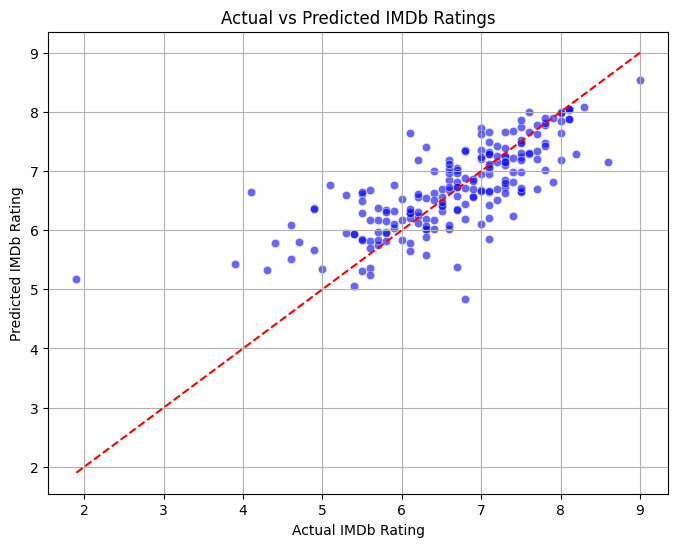

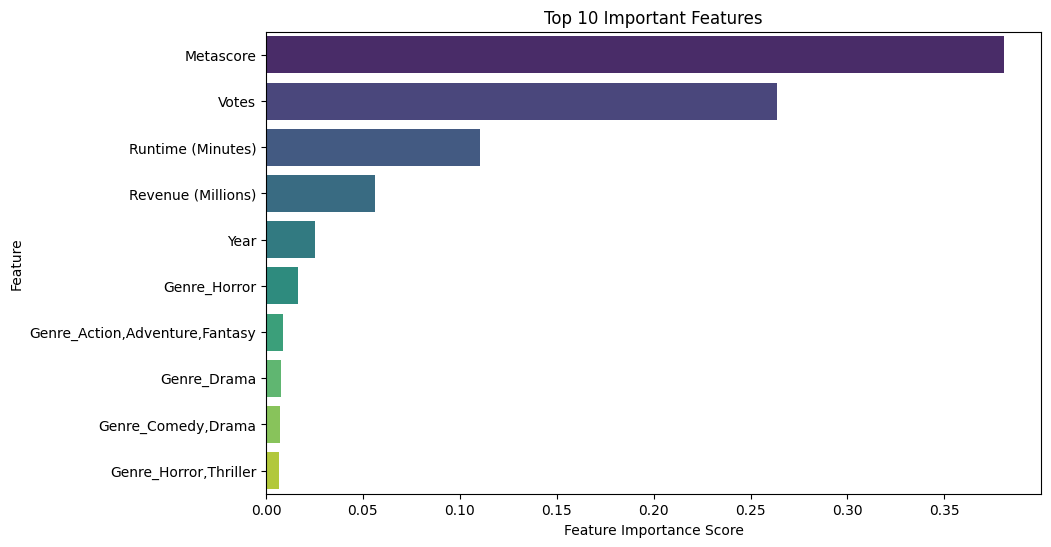

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load dataset
df = pd.read_csv("movie.csv")

# basic info
print("Dataset shape:", df.shape)
df.head()


# Clean and preprocess
df['Runtime (Minutes)'] = pd.to_numeric(df['Runtime (Minutes)'], errors='coerce')
df['Revenue (Millions)'] = pd.to_numeric(df['Revenue (Millions)'], errors='coerce')
df['Metascore'] = pd.to_numeric(df['Metascore'], errors='coerce')


# Handle missing values
df.fillna({
    'Metascore': df['Metascore'].median(),
    'Revenue (Millions)': df['Revenue (Millions)'].median(),
    'Runtime (Minutes)': df['Runtime (Minutes)'].median(),
    'Genre': 'Unknown'
}, inplace=True)

# Features and target
X = df[['Year', 'Runtime (Minutes)', 'Revenue (Millions)', 'Votes', 'Metascore', 'Genre']]
y = df['Rating']

# One-hot encode Genre
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['Genre'])
], remainder='passthrough')

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build Random Forest pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, random_state=42))
])

# Train the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation Metrics")
print("RMSE:", round(rmse, 3))
print("MAE:", round(mae, 3))
print("R2 Score:", round(r2, 3))


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, color='blue', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title('Actual vs Predicted IMDb Ratings')
plt.xlabel('Actual IMDb Rating')
plt.ylabel('Predicted IMDb Rating')
plt.grid(True)
plt.show()

# Get feature names after one-hot encoding
ohe = model.named_steps['preprocessor'].named_transformers_['cat']
encoded_genre = list(ohe.get_feature_names_out(['Genre']))
all_features = encoded_genre + ['Year', 'Runtime (Minutes)', 'Revenue (Millions)', 'Votes', 'Metascore']

# Get scores from Random Forest
importances = model.named_steps['regressor'].feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)[:10]

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index, hue=feat_imp.index, 
            palette='viridis', legend=False)
plt.title('Top 10 Important Features')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.show()
